In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Import required Libraries**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

# Load Data

In [4]:
batch_size = 32
img_height = 227
img_width = 227

data_dir = "/content/drive/MyDrive/TinyML/Datasets/Tomatoes Diseases/"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 10288 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 2572 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

# **Visualize the data**

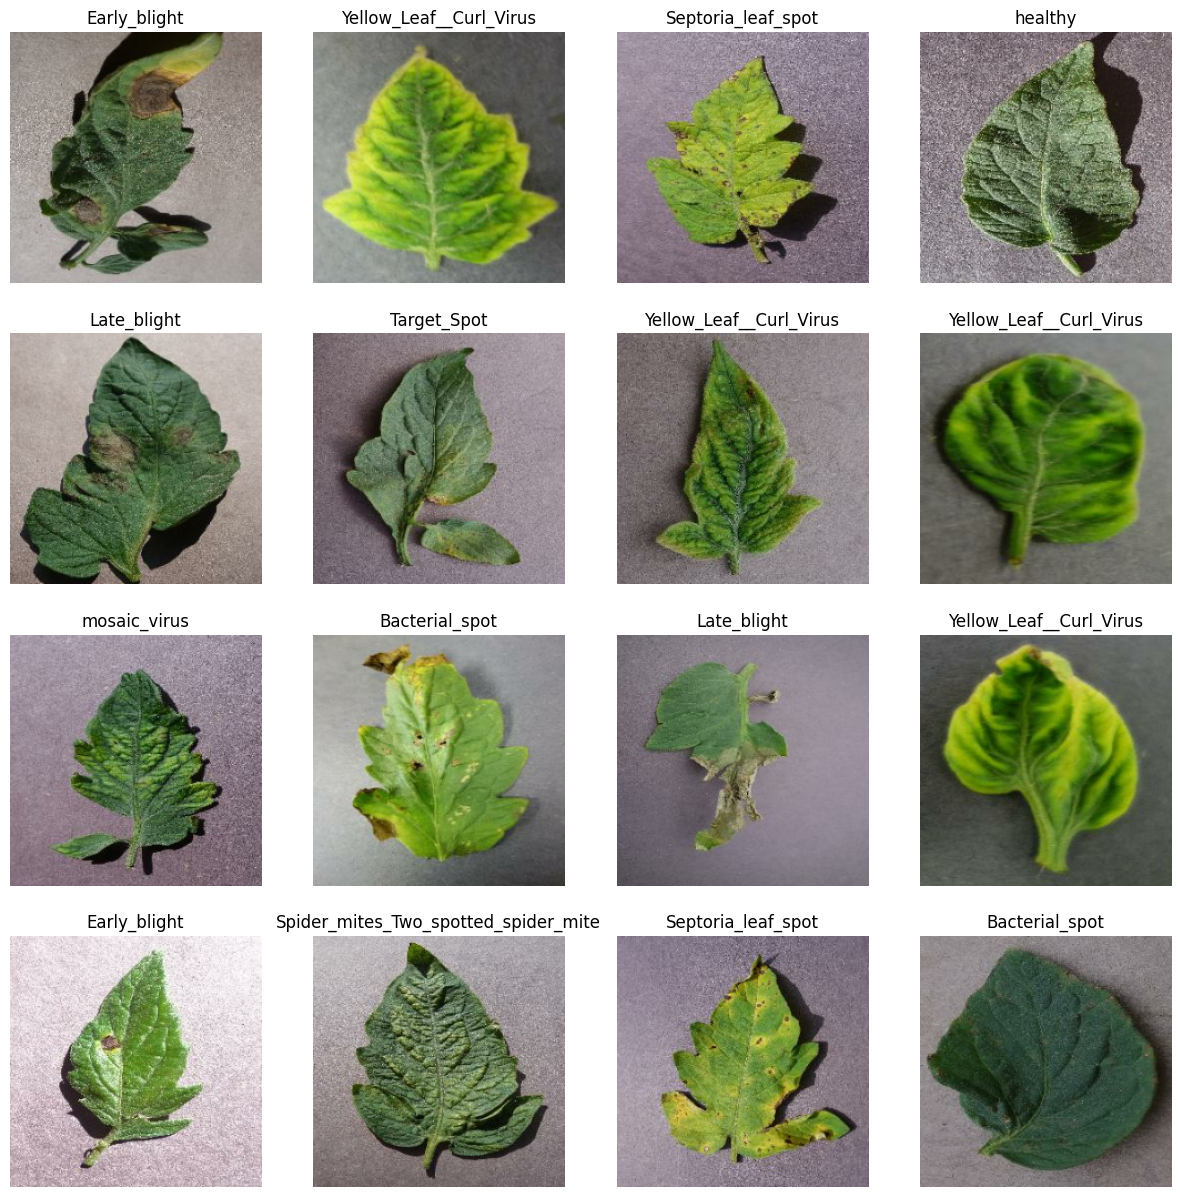

In [8]:
plt.figure(figsize=(15, 15))
for img, lab in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[lab[i]])
        plt.axis("off")

# Preprocess the data

In [9]:
# set 3200 images for training and 800 images for validation
train_ds = train_ds.take(100)
val_ds = val_ds.take(25)

In [10]:
# standardize the data

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_nds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_nds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_nds = train_nds.cache().prefetch(buffer_size=AUTOTUNE)
val_nds = val_nds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
print(train_nds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# **Train a model**

In [13]:
# Define AlexNet model

AlexNet = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=4, padding='valid', activation='relu', input_shape=(227, 227, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    tf.keras.layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    tf.keras.layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes
])

AlexNet.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  metrics=["accuracy"]
)
# Model summary

AlexNet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,9

 Total params: 58,327,818 (222.50 MB)

 Trainable params: 58,325,066 (222.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [14]:
# training the alexnet model

AlexNet_history = AlexNet.fit(
    train_nds,
    validation_data=val_nds,
    epochs=100
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 ━━━━━━━━━━━━━━━━━━━━ 617s 6s/step - accuracy: 0.2570 - loss: 3.5604 - val_accuracy: 0.2025 - val_loss: 2.3513
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.5498 - loss: 1.5631 - val_accuracy: 0.1225 - val_loss: 2.8392
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6316 - loss: 1.2021 - val_accuracy: 0.1775 - val_loss: 3.3544
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7108 - loss: 0.8868 - val_accuracy: 0.2150 - val_loss: 3.4996
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7511 - loss: 0.7557 - val_accuracy: 0.3262 - val_loss: 2.1131
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7831 - loss: 0.6113 - val_accuracy: 0.6263 - val_loss: 1.1135
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8126 - loss: 0.5313 - val_accuracy: 0.7962 - val_loss: 0.6070
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8457 - loss: 0.4444 - val_accu

# **Visualize the training results**

In [15]:
def plot_curves(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']

    epochs = range(len(his.history['loss']))

    # ploting the loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

    # ploting the accuracy
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()


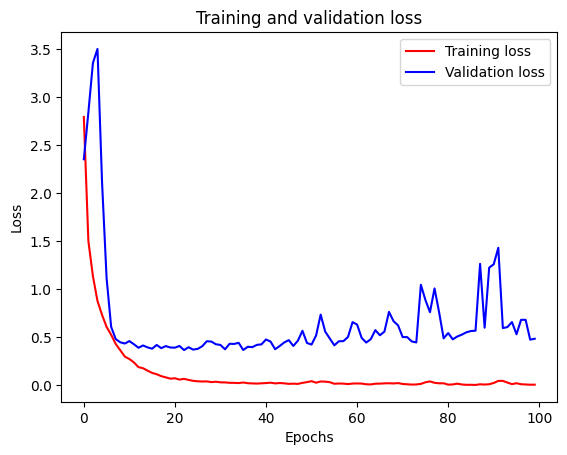

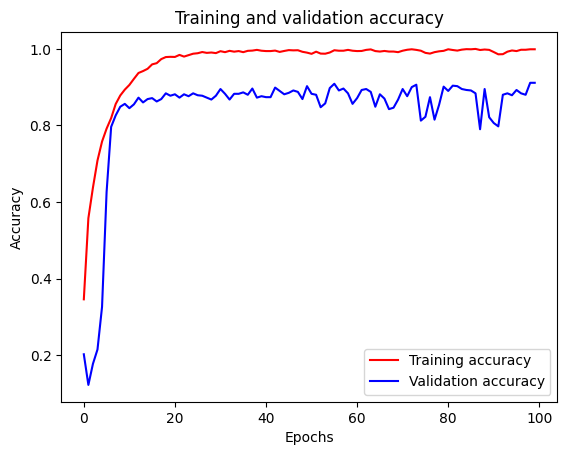

<Figure size 640x480 with 0 Axes>

In [16]:
plot_curves(AlexNet_history)

In [17]:
# saving the model to the disk

model = "/content/drive/MyDrive/TinyML/SaveModels/copy_AlexNet.h5"
tf.keras.models.save_model(AlexNet, model, include_optimizer=False)

# **Testing the model**

In [18]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 3198 files belonging to 10 classes.


In [19]:
class_names = test_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

In [20]:
test_ds = test_ds.take(10)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

test_nds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

test_nds = test_nds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
loss, acc = AlexNet.evaluate(test_nds)
print("Accuracy", acc)
print("Loss", loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9081 - loss: 0.4514
Accuracy 0.909375011920929
Loss 0.4332147538661957


In [23]:
# Get predictions
y_pred = AlexNet.predict(test_nds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_nds], axis=0)

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [24]:
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[32,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1,  9,  8,  1,  0,  1,  3,  0,  0,  0],
       [ 0,  0, 37,  1,  1,  0,  0,  2,  0,  0],
       [ 0,  0,  0, 13,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  1, 30,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 34,  3,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1, 30,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 68,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 26,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 12]], dtype=int32)>

Text(0.5, 1.0, 'Confusion Matrix')

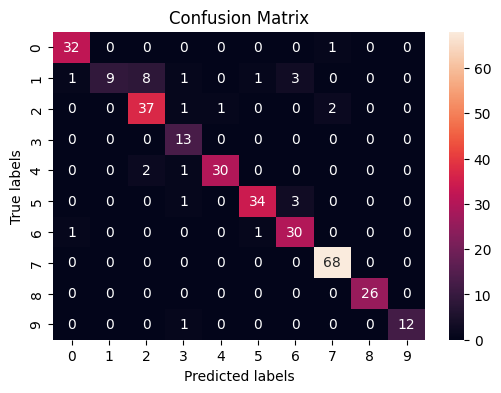

In [25]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

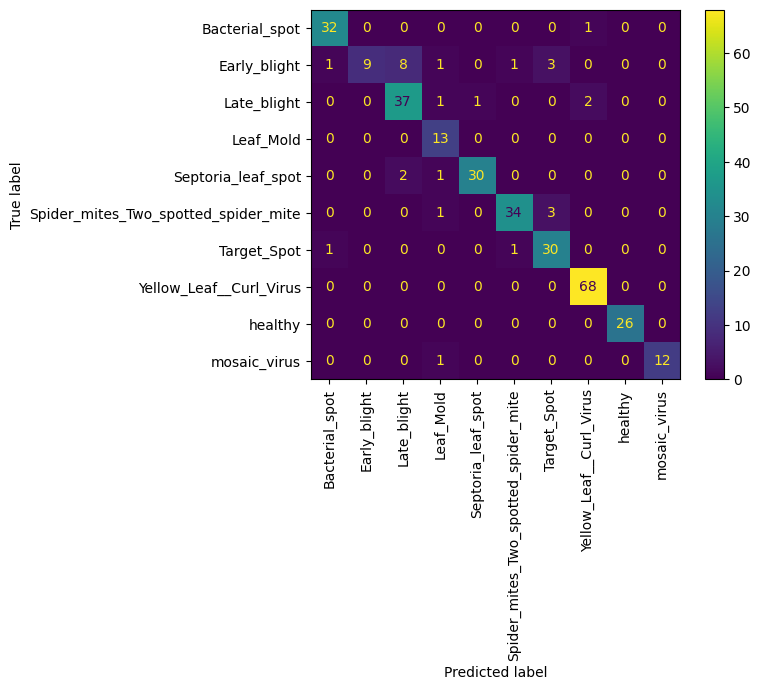

In [26]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=class_names, xticks_rotation='vertical'
)

In [27]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Accuracy", acc)
print("Loss", loss)

Precision: 0.9153898927498536
Recall: 0.8927845016186395
F1 Score: 0.8874531775207901
Accuracy 0.909375011920929
Loss 0.4332147538661957
